In [2]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

batch_size = 32
img_height = 180
img_width = 180

# Define the data transformations
data_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Specify the paths to your train and validation datasets
path_train = "Cat_Dog/train/"
path_validate = "Cat_Dog/test/"

# Create a dataset using torchvision ImageFolder
train_dataset = torchvision.datasets.ImageFolder(
    root=path_train,
    transform=data_transform,
)

validate_dataset = torchvision.datasets.ImageFolder(
    root=path_validate,
    transform=data_transform,
)

# Split the train_dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))
validate_size = len(train_dataset) - train_size
train_dataset, validate_dataset = random_split(train_dataset, [train_size, validate_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

# Get the class names
class_names = train_dataset.dataset.classes
class_name = {i + 1: class_names[i] for i in range(len(class_names))}

print(class_names)
print(class_name)


['cats', 'dogs']
{1: 'cats', 2: 'dogs'}


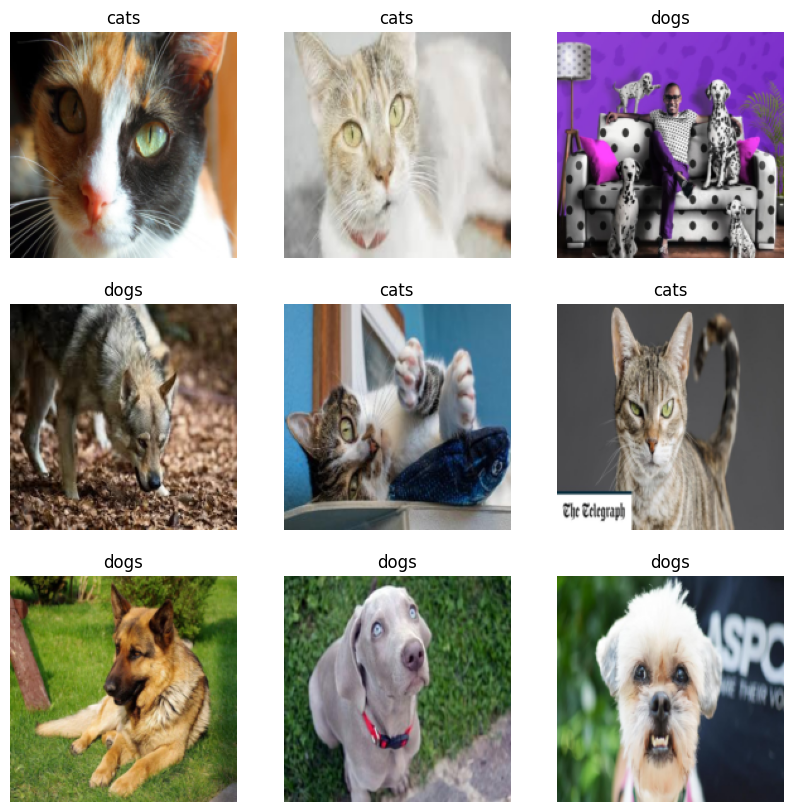

In [3]:
import matplotlib.pyplot as plt

count = 0  # Initialize a count to keep track of how many images have been plotted

plt.figure(figsize=(10, 10))

for images, labels in train_loader:
    for i in range(len(images)):  # Iterate over all available images in the batch
        if count >= 9:
            break  # Exit the loop if you've plotted 9 images
        ax = plt.subplot(3, 3, count + 1)

        # Ensure that the image data is in the correct format (e.g., HWC for PyTorch)
        image = images[i].permute(1, 2, 0).numpy()

        # If your data is not in the range [0, 1], you may need to adjust the scaling
        plt.imshow(image)
        plt.title(class_names[labels[i]])
        plt.axis("off")
        count += 1
    if count >= 9:
        break  # Exit the outer loop if you've plotted 9 images

plt.show()


In [4]:
import torch
import torch.nn as nn

num_classes = len(class_names)

class Net(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the input shape and number of classes
# img_height, img_width, num_classes = 224, 224, 10  # Adjust the values as needed

# Create the model
model = Net(num_classes, img_height, img_width)

print(f"No of Classes : {num_classes}")

No of Classes : 2


In [5]:
import torch
import torch.optim as optim
import torch.nn as nn

# Define your PyTorch model (assuming you have already defined it)
# model = Net()  # Instantiate your model
model = Net(num_classes, img_height, img_width) # Instantiate your model

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters())

# Define the loss function (e.g., Sparse Categorical Cross-Entropy)
criterion = nn.CrossEntropyLoss()

# Optionally, you can also specify any additional metrics you want to track during training.

# Example metric function (accuracy)
def accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.size(0)
    return correct / total

# This is just an example; you can add more metrics as needed.

# You can then use these objects during your training loop.

In [6]:
def summary(model, input_size):
    print(model)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params}")
    print(f"Input Size: {input_size}")

# Example usage of the summary function
input_size = (3, img_height, img_width)  # Adjust the input size based on your data
summary(model, input_size)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=30976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Total Trainable Parameters: 3988898
Input Size: (3, 180, 180)


In [7]:
import torch
import torch.optim as optim
import torch.nn as nn

# Assuming you've already defined your model, optimizer, loss function, and data loaders

# Specify the number of epochs
epochs = 20

# Define a function for training
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            running_loss += loss.item()
            total_samples += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        # Calculate accuracy and print the average loss for the current epoch
        accuracy = 100.0 * correct_predictions / total_samples
        average_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {average_loss:.4f} - Accuracy: {accuracy:.2f}%")
        running_loss = 0.0
        total_samples = 0
        correct_predictions = 0

# Train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Assuming you have defined train_loader
train_model(model, train_loader, optimizer, criterion, device)

Epoch [1/20] - Loss: 0.7185 - Accuracy: 51.57%
Epoch [2/20] - Loss: 0.6915 - Accuracy: 52.69%
Epoch [3/20] - Loss: 0.6836 - Accuracy: 57.17%
Epoch [4/20] - Loss: 0.6627 - Accuracy: 60.54%
Epoch [5/20] - Loss: 0.6395 - Accuracy: 63.45%
Epoch [6/20] - Loss: 0.5923 - Accuracy: 69.06%
Epoch [7/20] - Loss: 0.5660 - Accuracy: 70.85%
Epoch [8/20] - Loss: 0.5377 - Accuracy: 72.42%
Epoch [9/20] - Loss: 0.4734 - Accuracy: 80.27%
Epoch [10/20] - Loss: 0.4044 - Accuracy: 80.72%
Epoch [11/20] - Loss: 0.3261 - Accuracy: 86.55%
Epoch [12/20] - Loss: 0.3088 - Accuracy: 86.77%
Epoch [13/20] - Loss: 0.2222 - Accuracy: 91.03%
Epoch [14/20] - Loss: 0.1511 - Accuracy: 95.96%
Epoch [15/20] - Loss: 0.1188 - Accuracy: 95.96%
Epoch [16/20] - Loss: 0.0625 - Accuracy: 98.21%
Epoch [17/20] - Loss: 0.0482 - Accuracy: 98.88%
Epoch [18/20] - Loss: 0.0277 - Accuracy: 99.78%
Epoch [19/20] - Loss: 0.0276 - Accuracy: 99.55%
Epoch [20/20] - Loss: 0.0272 - Accuracy: 99.33%


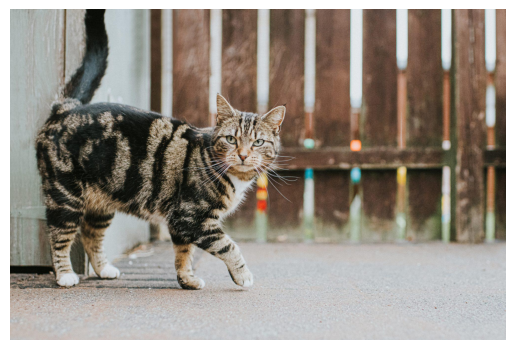

In [8]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Path to the image
path = "Cat_Dog/train/cats/cat_10.jpg"

# Load and display the image using PIL and Matplotlib
img = Image.open(path)

plt.imshow(img)
plt.axis('off')
plt.show()


In [9]:
import torch
from torchvision import transforms
from PIL import Image

# Path to the image
# path = "mango_dataset/test/Healthy/healthy_146.jpg"

# Define transformations and preprocessing
preprocess = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Load and preprocess the image, then remove alpha channel if it exists
img = Image.open(path).convert('RGB')
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Make a prediction with your PyTorch model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    prediction = model(img)

# Get the predicted class
predicted_class = torch.argmax(prediction).item()

print(f"Predicted class: {predicted_class}")
print(f"Predicted animal: {class_names[predicted_class]}")

Predicted class: 0
Predicted animal: cats
